## Solutions (DAY 2)

## Logistic Regression

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
import sklearn.model_selection

#from sklearn import model_selection

c0=sns.color_palette()[0]
c1=sns.color_palette()[1]
c2=sns.color_palette()[2]

cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

In [2]:
def points_plot(ax, Xtr, Xte, ytr, yte, clf, mesh=True, colorscale=cmap_light, 
                cdiscrete=cmap_bold, alpha=0.1, psize=10, zfunc=False, predicted=False):
    h = .02
    X=np.concatenate((Xtr, Xte))
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))

    #plt.figure(figsize=(10,6))
    if zfunc:
        p0 = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 0]
        p1 = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
        Z=zfunc(p0, p1)
    else:
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    ZZ = Z.reshape(xx.shape)
    if mesh:
        plt.pcolormesh(xx, yy, ZZ, cmap=cmap_light, alpha=alpha, axes=ax)
    if predicted:
        showtr = clf.predict(Xtr)
        showte = clf.predict(Xte)
    else:
        showtr = ytr
        showte = yte
    ax.scatter(Xtr[:, 0], Xtr[:, 1], c=showtr-1, cmap=cmap_bold, 
               s=psize, alpha=alpha,edgecolor="k")
    # and testing points
    ax.scatter(Xte[:, 0], Xte[:, 1], c=showte-1, cmap=cmap_bold, 
               alpha=alpha, marker="s", s=psize+10)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    return ax,xx,yy

In [3]:
# Load the pggm dataset
pggm = pd.read_csv('PGGM_dataset.csv')

In [4]:
# Inspect the data set using a dataframe and fix missing data by deleting

In [5]:
pggm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38304 entries, 0 to 38303
Data columns (total 18 columns):
Identifier               38304 non-null object
Name                     38304 non-null object
Period                   38304 non-null object
Period_YYYYMMDD          38304 non-null int64
Ticker                   38304 non-null object
Universe_Returns_F1W     38300 non-null float64
Universe_Returns_F4W     38296 non-null float64
Universe_Returns_F12W    38268 non-null float64
Weight                   38304 non-null float64
GICS_Sector              38304 non-null object
GICS_Ind_Grp             38304 non-null object
Market_Cap_USD           38304 non-null float64
Price_USD                38304 non-null float64
NTM_EP                   38246 non-null float64
LTM_ROA                  38245 non-null float64
BP                       38288 non-null float64
LTM_EP                   38215 non-null float64
5Y_Sales_Growth          38197 non-null float64
dtypes: float64(11), int64(1), obje

In [6]:
# Remove missing data
pggm = pggm.dropna()

In [7]:
# add a new column to pggm called Universe_Returns_F4W_cat which is 1 if Universe_Returns_F4W values is positive and -1 otherwise

In [8]:
pggm['Universe_Returns_F4W_cat'] = np.where(pggm['Universe_Returns_F4W']>=0, 1, -1)

In [80]:
pggm.groupby('Universe_Returns_F4W_cat').count()['Identifier']

Universe_Returns_F4W_cat
-1    18167
 1    19859
Name: Identifier, dtype: int64

In [9]:
pggm.head()

,Identifier,Name,Period,Period_YYYYMMDD,Ticker,Universe_Returns_F1W,Universe_Returns_F4W,Universe_Returns_F12W,Weight,GICS_Sector,GICS_Ind_Grp,Market_Cap_USD,Price_USD,NTM_EP,LTM_ROA,BP,LTM_EP,5Y_Sales_Growth,Universe_Returns_F4W_cat
0,17290810,Cintas Corporation,12/31/2014,20141231,CTAS-US,-2.517855,-0.121111,4.156041,0.000402,Industrials,Commercial & Professional Services,7761.120,78.44,0.044387,9.089989,0.246962,0.042708,4.718765,-1
1,80589M10,SCANA Corporation,12/31/2014,20141231,SCG-US,2.036428,6.307948,-8.426744,0.000422,Utilities,Utilities,8151.001,60.40,0.061397,3.472852,0.572871,0.062748,-0.949881,1
2,50241310,L-3 Communications Holdings Inc.,12/31/2014,20141231,LLL-US,-0.396162,-1.283580,-0.753021,0.000563,Industrials,Capital Goods,10883.341,126.21,0.060554,4.744629,0.570099,0.059821,-4.316938,-1
3,91301710,United Technologies Corporation,12/31/2014,20141231,UTX-US,-1.973909,1.669562,1.815629,0.005174,Industrials,Capital Goods,99942.990,115.00,0.062889,6.805052,0.325584,0.059088,3.083364,1
4,92939U10,Wisconsin Energy Corporation,12/31/2014,20141231,WEC-US,1.118696,7.679176,-6.160975,0.000616,Utilities,Utilities,11893.872,52.74,0.051359,4.201019,0.369798,0.050815,1.421392,1


In [78]:
# The earnings yield is the ratio of a company's last twelve months (LTM) of earnings per share (EPS) to its stock price
#Universe_Returns_F12W

In [11]:
X = pggm.iloc[:, [7,16]] #Universe_Returns_F12W  #LTM_EP
y = pggm.iloc[:, 18] 

In [12]:
# Split the data into training/testing sets in a ratio of 70/30

In [13]:
from sklearn.model_selection import train_test_split  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30) 

In [14]:
# Train the model using the training set

In [15]:
from sklearn.linear_model import LogisticRegression
regressor = LogisticRegression()

In [16]:
regressor.fit(X=np.array(X_train), y=y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [17]:
# Make predictions using the testing set

In [18]:
y_pred = regressor.predict(X_test)

In [19]:
from sklearn.metrics import accuracy_score
print(accuracy_score(regressor.predict(X_test), y_test.values.reshape(-1, 1)))

0.7046809256661991


In [20]:
# plot outputs hint: use point_plot by copying the method from the logistic regression notebook

Text(0,0.5,'Universal returns 12w')

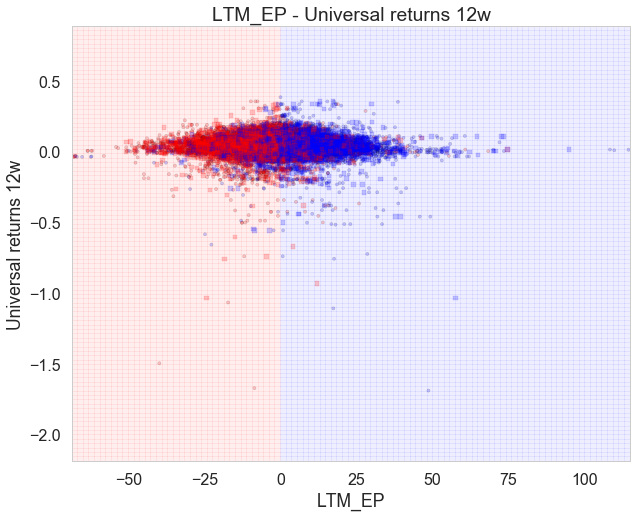

In [21]:
plt.figure(figsize=(10,8))
ax=plt.gca()
points_plot(ax, np.array(X_train), np.array(X_test), y_train, y_test, regressor, alpha=0.2);
plt.title('LTM_EP - Universal returns 12w')
plt.xlabel('LTM_EP')
plt.ylabel('Universal returns 12w')

In [22]:
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.001, 0.1, 1],'penalty' : ['l2', 'l1'] }
clf = GridSearchCV(LogisticRegression(), param_grid, cv=10)
clf.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [0.001, 0.1, 1], 'penalty': ['l2', 'l1']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

The C parameter tells the Parametric Classifier optimization how much you want to avoid misclassifying each training example. For large values of C, the optimization will choose a smaller-margin hyperplane if that hyperplane does a better job of getting all the training points classified correctly. Conversely, a very small value of C will cause the optimizer to look for a larger-margin separating hyperplane, even if that hyperplane misclassifies more points. For very tiny values of C, you should get misclassified examples, often even if your training data is linearly separable

In [23]:
clf.best_params_

{'C': 0.001, 'penalty': 'l1'}

In [24]:
regressor = LogisticRegression(penalty='l1',C=0.001)
regressor.fit(X_train, y_train)

LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [25]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

result = 0
folds = 10
for train, test in KFold(folds).split(X): # split data into train/test groups, 10 times
    regressor.fit(X_train, y_train) # fit
    result += accuracy_score(regressor.predict(X_test), y_test) # evaluate score function on held-out data
print("Accuracy: {0:.5f}".format(result / folds)) # average

Accuracy: 0.71012


## Naive Bayesian

#### Methodology
<ol>
<li> split the data set into a training and test set in 80/20 ratio
<li> Use `scikit-learn`'s `MultinomialNB()` classifier with default parameters.
<li> train the classifier over the training set and test on the test set
<li> print the accuracy scores for both the training and the test sets
</ol>

What do you notice? Is this a good classifier? If not, why not?

In [26]:
# Implement a simple Naive Bayes classifier on pggm dataset using Universe_Returns_F1W and Price_USD as input and sales_growth_class as output like the logistic regression exercise.

In [27]:
import pandas as pd

In [28]:
# Load the pggm dataset
pggm = pd.read_csv('pggm_dataset.csv')

In [29]:
pggm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38304 entries, 0 to 38303
Data columns (total 18 columns):
Identifier               38304 non-null object
Name                     38304 non-null object
Period                   38304 non-null object
Period_YYYYMMDD          38304 non-null int64
Ticker                   38304 non-null object
Universe_Returns_F1W     38300 non-null float64
Universe_Returns_F4W     38296 non-null float64
Universe_Returns_F12W    38268 non-null float64
Weight                   38304 non-null float64
GICS_Sector              38304 non-null object
GICS_Ind_Grp             38304 non-null object
Market_Cap_USD           38304 non-null float64
Price_USD                38304 non-null float64
NTM_EP                   38246 non-null float64
LTM_ROA                  38245 non-null float64
BP                       38288 non-null float64
LTM_EP                   38215 non-null float64
5Y_Sales_Growth          38197 non-null float64
dtypes: float64(11), int64(1), obje

In [30]:
# Remove missing data
pggm = pggm.dropna()

In [31]:
import numpy as np
pggm['Universe_Returns_F4W_cat'] = np.where(pggm['Universe_Returns_F4W']>=0, 1, -1)

In [32]:
pggm.head()

,Identifier,Name,Period,Period_YYYYMMDD,Ticker,Universe_Returns_F1W,Universe_Returns_F4W,Universe_Returns_F12W,Weight,GICS_Sector,GICS_Ind_Grp,Market_Cap_USD,Price_USD,NTM_EP,LTM_ROA,BP,LTM_EP,5Y_Sales_Growth,Universe_Returns_F4W_cat
0,17290810,Cintas Corporation,12/31/2014,20141231,CTAS-US,-2.517855,-0.121111,4.156041,0.000402,Industrials,Commercial & Professional Services,7761.120,78.44,0.044387,9.089989,0.246962,0.042708,4.718765,-1
1,80589M10,SCANA Corporation,12/31/2014,20141231,SCG-US,2.036428,6.307948,-8.426744,0.000422,Utilities,Utilities,8151.001,60.40,0.061397,3.472852,0.572871,0.062748,-0.949881,1
2,50241310,L-3 Communications Holdings Inc.,12/31/2014,20141231,LLL-US,-0.396162,-1.283580,-0.753021,0.000563,Industrials,Capital Goods,10883.341,126.21,0.060554,4.744629,0.570099,0.059821,-4.316938,-1
3,91301710,United Technologies Corporation,12/31/2014,20141231,UTX-US,-1.973909,1.669562,1.815629,0.005174,Industrials,Capital Goods,99942.990,115.00,0.062889,6.805052,0.325584,0.059088,3.083364,1
4,92939U10,Wisconsin Energy Corporation,12/31/2014,20141231,WEC-US,1.118696,7.679176,-6.160975,0.000616,Utilities,Utilities,11893.872,52.74,0.051359,4.201019,0.369798,0.050815,1.421392,1


In [33]:
X = pggm.iloc[:, [7,16]]
y = pggm.iloc[:, 18]  

In [34]:
from sklearn.model_selection import train_test_split  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20) 

In [35]:
from sklearn.naive_bayes import GaussianNB
classifier = GaussianNB()
classifier.fit(X_train, y_train)

GaussianNB(priors=None)

In [36]:
y_pred = classifier.predict(X_test)

In [37]:
from sklearn.metrics import confusion_matrix

In [38]:
confusion_matrix(y_test, y_pred)

array([[2424, 1254],
       [ 969, 2959]])

In [39]:
from sklearn.metrics import accuracy_score
print(accuracy_score(classifier.predict(X_test), y_test.values.reshape(-1, 1)))

0.7077307388903498


In [40]:
print(accuracy_score(classifier.predict(X_train), y_train.values.reshape(-1, 1)))

0.7055555555555556


## Support Vector Machine - Classification (SVM)

In [41]:
import numpy as np

In [42]:
# Load the pggm dataset
pggm = pd.read_csv('pggm_dataset.csv')

In [43]:
pggm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38304 entries, 0 to 38303
Data columns (total 18 columns):
Identifier               38304 non-null object
Name                     38304 non-null object
Period                   38304 non-null object
Period_YYYYMMDD          38304 non-null int64
Ticker                   38304 non-null object
Universe_Returns_F1W     38300 non-null float64
Universe_Returns_F4W     38296 non-null float64
Universe_Returns_F12W    38268 non-null float64
Weight                   38304 non-null float64
GICS_Sector              38304 non-null object
GICS_Ind_Grp             38304 non-null object
Market_Cap_USD           38304 non-null float64
Price_USD                38304 non-null float64
NTM_EP                   38246 non-null float64
LTM_ROA                  38245 non-null float64
BP                       38288 non-null float64
LTM_EP                   38215 non-null float64
5Y_Sales_Growth          38197 non-null float64
dtypes: float64(11), int64(1), obje

In [44]:
# Remove missing data
pggm = pggm.dropna()

In [45]:
pggm['Universe_Returns_F4W_cat'] = np.where(pggm['Universe_Returns_F4W']>=0, 1, -1)

In [46]:
pggm.head()

,Identifier,Name,Period,Period_YYYYMMDD,Ticker,Universe_Returns_F1W,Universe_Returns_F4W,Universe_Returns_F12W,Weight,GICS_Sector,GICS_Ind_Grp,Market_Cap_USD,Price_USD,NTM_EP,LTM_ROA,BP,LTM_EP,5Y_Sales_Growth,Universe_Returns_F4W_cat
0,17290810,Cintas Corporation,12/31/2014,20141231,CTAS-US,-2.517855,-0.121111,4.156041,0.000402,Industrials,Commercial & Professional Services,7761.120,78.44,0.044387,9.089989,0.246962,0.042708,4.718765,-1
1,80589M10,SCANA Corporation,12/31/2014,20141231,SCG-US,2.036428,6.307948,-8.426744,0.000422,Utilities,Utilities,8151.001,60.40,0.061397,3.472852,0.572871,0.062748,-0.949881,1
2,50241310,L-3 Communications Holdings Inc.,12/31/2014,20141231,LLL-US,-0.396162,-1.283580,-0.753021,0.000563,Industrials,Capital Goods,10883.341,126.21,0.060554,4.744629,0.570099,0.059821,-4.316938,-1
3,91301710,United Technologies Corporation,12/31/2014,20141231,UTX-US,-1.973909,1.669562,1.815629,0.005174,Industrials,Capital Goods,99942.990,115.00,0.062889,6.805052,0.325584,0.059088,3.083364,1
4,92939U10,Wisconsin Energy Corporation,12/31/2014,20141231,WEC-US,1.118696,7.679176,-6.160975,0.000616,Utilities,Utilities,11893.872,52.74,0.051359,4.201019,0.369798,0.050815,1.421392,1


In [47]:
X = pggm.iloc[:, [7,16]]
y = pggm.iloc[:, 18] 

In [48]:
from sklearn.model_selection import train_test_split  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20) 

In [49]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [50]:
from sklearn.svm import SVC
classifier = SVC(kernel='linear', random_state=0)
classifier.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=0, shrinking=True,
  tol=0.001, verbose=False)

In [51]:
y_pred = classifier.predict(X_test)

In [52]:
from sklearn.metrics import confusion_matrix

In [53]:
confusion_matrix(y_test, y_pred)

array([[2427, 1183],
       [1041, 2955]])

In [54]:
from sklearn.metrics import accuracy_score
print(accuracy_score(classifier.predict(X_test), y_test.values.reshape(-1, 1)))

0.7075992637391533


In [55]:
print(accuracy_score(classifier.predict(X_train), y_train.values.reshape(-1, 1)))

0.7081854043392505


In [56]:
classifier = SVC(kernel='poly', random_state=0)
classifier.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='poly',
  max_iter=-1, probability=False, random_state=0, shrinking=True,
  tol=0.001, verbose=False)

In [57]:
y_pred = classifier.predict(X_test)

In [58]:
confusion_matrix(y_test, y_pred)

array([[ 797, 2813],
       [ 187, 3809]])

In [59]:
print(accuracy_score(classifier.predict(X_test), y_test.values.reshape(-1, 1)))

0.6055745464107284


In [60]:
print(accuracy_score(classifier.predict(X_train), y_train.values.reshape(-1, 1)))

0.6057527942143327


In [61]:
classifier = SVC(kernel='rbf', random_state=0)
classifier.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=0, shrinking=True,
  tol=0.001, verbose=False)

In [62]:
y_pred = classifier.predict(X_test)

In [63]:
confusion_matrix(y_test, y_pred)

array([[2512, 1098],
       [1119, 2877]])

In [64]:
print(accuracy_score(classifier.predict(X_test), y_test.values.reshape(-1, 1)))

0.7085195897975283


In [65]:
print(accuracy_score(classifier.predict(X_train), y_train.values.reshape(-1, 1)))

0.710749506903353


## Random Forest 

In [66]:
# Implement a random forest classifier on pggm dataset using Universe_Returns_F12W and LTM_EP as input 
# and Universe_Returns_F4W_cat as output using the notebook example parameters
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [67]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [68]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators=20, random_state=0, criterion='gini', oob_score=True )
classifier.fit(X_train, y_train)

/Users/pedrohserrano/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
            oob_score=True, random_state=0, verbose=0, warm_start=False)

In [69]:
y_pred = classifier.predict(X_test)

In [70]:
classifier.oob_score_

0.658809993425378

In [71]:
from sklearn.metrics import accuracy_score

print(accuracy_score(classifier.predict(X_test), y_test.values.reshape(-1, 1)))

0.6731527741256902


In [72]:
for feature, imp in zip(pggm.columns[[7,16]], classifier.feature_importances_):
    print(feature, imp)

Universe_Returns_F12W 0.6123969931814448
LTM_EP 0.3876030068185553


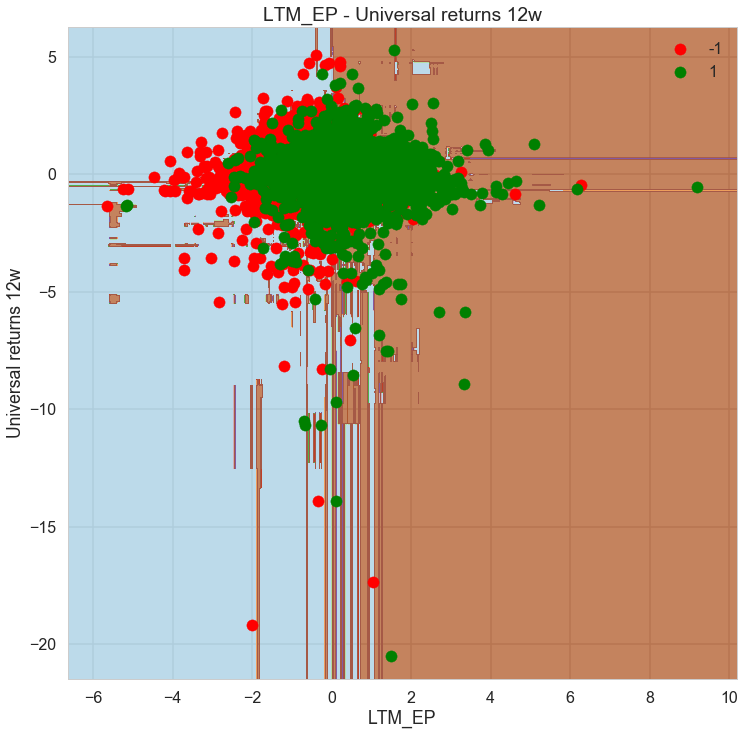

In [75]:
from matplotlib.colors import ListedColormap
X_set, y_set = X_test, y_test
X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1, stop = X_set[:, 0].max() + 1, step = 0.01),
                     np.arange(start = X_set[:, 1].min() - 1, stop = X_set[:, 1].max() + 1, step = 0.01))
plt.figure(figsize=(12,12))
plt.contourf(X1, X2, classifier.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
             alpha = 0.75, cmap = plt.cm.Paired)
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())
for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                c = ListedColormap(('red', 'green'))(i), label = j)
plt.title('Classifier (Test set)')
plt.title('LTM_EP - Universal returns 12w')
plt.xlabel('LTM_EP')
plt.ylabel('Universal returns 12w')
plt.legend()